# Install the libraries


In [17]:
%pip install numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import & Split the dataset

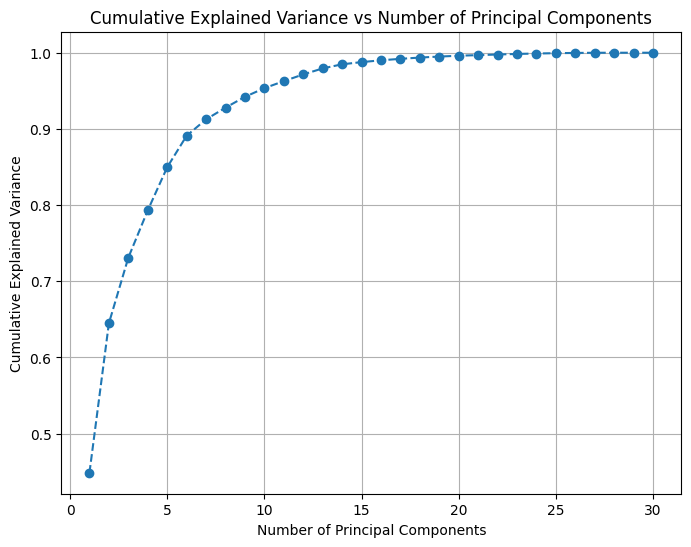

Optimal number of components for 95% variance: 10


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar o dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# Normalizar a informacao
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular o numero de componentes necessarios
# para manter 95% da informacao
pca = PCA()
pca.fit(X_train_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

num_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Optimal number of components for 95% variance: {num_components}')


In [19]:
# Aplicar o PCA apos calcular o numero de componentes
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Regressao Logistica
model = LogisticRegression(max_iter = 2000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred)

model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred)


print(f"Accuracy = {accuracy},\n")
print(f"Accuracy Scaled = {accuracy_scaled},\n")
print(f"Accuracy PCA = {accuracy_pca},\n")


Accuracy = 0.9649122807017544,

Accuracy Scaled = 0.9766081871345029,

Accuracy PCA = 0.9766081871345029,



/home/rantas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# EM Clustering

In [21]:
import matplotlib.pyplot as plt

# Desenha 2 graficos, o primeiro compara o valor de silhueta com o numero de clusters
# O segundo compara a accuracy com o numero de clusters
def plot_graphs(accuracy_scores, silhouette_scores, k_values, covariance_type):
   
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    ax[0].plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
    ax[0].set_title(f'Silhouette Score vs. Number of Clusters for {covariance_type}', fontsize=14)
    ax[0].set_xlabel('Number of Clusters', fontsize=12)
    ax[0].set_ylabel('Silhouette Score', fontsize=12)
    ax[0].set_xticks(k_values)
    ax[0].grid(True)

    ax[1].plot(k_values, accuracy_scores, marker='o', linestyle='-', color='g')
    ax[1].set_title(f'Accuracy Score vs. Number of Clusters for {covariance_type}', fontsize=14)
    ax[1].set_xlabel('Number of Clusters', fontsize=12)
    ax[1].set_ylabel('Accuracy Score', fontsize=12)
    ax[1].set_xticks(k_values)
    ax[1].grid(True)

    plt.tight_layout()

    plt.show()

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np

# Calcula o melhor numero de clusters de forma a maximizar o valor de silhueta e a accuracy
def EM_Clustering(covariance_type, X_train, X_test, y_test):
    
    k_values = range(2, 151)
    silhouette_scores = []
    accuracy_scores = []
    
    for k in k_values:
        em = GaussianMixture(n_components=k, covariance_type=covariance_type,n_init=5) 
        cluster_labels = em.fit_predict(X_train)
        silhouette_avg = silhouette_score(X_train, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        probabilities = em.predict_proba(X_test)
        new_model = LogisticRegression(max_iter = 2000)
        new_model.fit(probabilities, y_test)
        predictions = new_model.predict(probabilities)
        new_accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(new_accuracy)
        print(f'For k={k}, Silhouette Score: {silhouette_avg}, Accuracy Score: {new_accuracy}')

    # Find optimal k with the highest silhouette score
    optimal_k_sil = k_values[np.argmax(silhouette_scores)]
    optimal_k_acc = k_values[np.argmax(accuracy_scores)]
 

    print(f'Optimal number of clusters from silhouette: {optimal_k_sil} with value {max(silhouette_scores)}')
    print(f'Optimal number of clusters from accuracy: {optimal_k_acc} with value {max(accuracy_scores)}')
   
    
    plot_graphs(accuracy_scores, silhouette_scores, k_values, covariance_type)

    return (optimal_k_sil, optimal_k_acc)


# RBFN

In [23]:
from scipy.spatial.distance import cdist

# Funcao que aplica a gaussian radial basis function
def rbf_transform(X, centers, betas):
    
    dists = cdist(X, centers, metric='sqeuclidean')
    betas = np.asarray(betas)
    transformed_X = np.exp(-dists * betas[np.newaxis, :])
    
    return transformed_X

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Desenha a matriz de confusao
def plot_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data.target_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="Greens", ax=ax)

   
    metrics_text = f"Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}"
    ax.text(
        0.5, -0.15, metrics_text, 
        ha='center', va='top', transform=ax.transAxes, 
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white')
    )

    plt.tight_layout()
    plt.show()

In [25]:
# Variaveis que guardam os valores dos clusters otimos
optimal_sil = [0] * 3
optimal_acc = [0] * 3

In [26]:
# Calculo dos betas
def betas_calc(components, X_train, centers, labels):

    betas = []

    for i in range(components):
        
        cluster_points = X_train[labels == i]
    
        cluster_center = centers[i]
        
        dists = np.linalg.norm(cluster_points - cluster_center, axis=1)
    
        
        avg_dist = np.mean(dists)
    
        betas.append(0.5/ (avg_dist**2))

    return betas

In [27]:
# Funcao que aplica a RBFN
def RBFN(components, cov_type, X_train, X_test, y_train, y_test):

    gmm = GaussianMixture(n_components=components, covariance_type=cov_type, n_init=10).fit(X_train)
    labels = gmm.predict(X_train)
    centers = gmm.means_

    betas = betas_calc(components, X_train, centers, labels)

    X_train_rbf = rbf_transform(X_train, centers, betas)
    X_test_rbf = rbf_transform(X_test, centers, betas)

    model = LogisticRegression()
    model.fit(X_train_rbf, y_train)

    y_pred = model.predict(X_test_rbf)
    
    plot_confusion_matrix(y_test, y_pred)

## Base

### Full

For k=2, Silhouette Score: 0.6294557068562594, Accuracy Score: 0.9415204678362573
For k=3, Silhouette Score: 0.5164461424197685, Accuracy Score: 0.935672514619883
For k=4, Silhouette Score: 0.5015428284026117, Accuracy Score: 0.8654970760233918
For k=5, Silhouette Score: 0.4377073767625745, Accuracy Score: 0.8830409356725146
For k=6, Silhouette Score: 0.4881695337206353, Accuracy Score: 0.8713450292397661
For k=7, Silhouette Score: 0.48210931894908543, Accuracy Score: 0.8713450292397661
For k=8, Silhouette Score: 0.46782651470480985, Accuracy Score: 0.9005847953216374
For k=9, Silhouette Score: 0.42649446033836264, Accuracy Score: 0.8830409356725146
For k=10, Silhouette Score: 0.45750027480980376, Accuracy Score: 0.8830409356725146
For k=11, Silhouette Score: 0.46023261889923167, Accuracy Score: 0.8947368421052632
For k=12, Silhouette Score: 0.43322304529638145, Accuracy Score: 0.8947368421052632
For k=13, Silhouette Score: 0.4299082069616699, Accuracy Score: 0.8771929824561403
For k=1

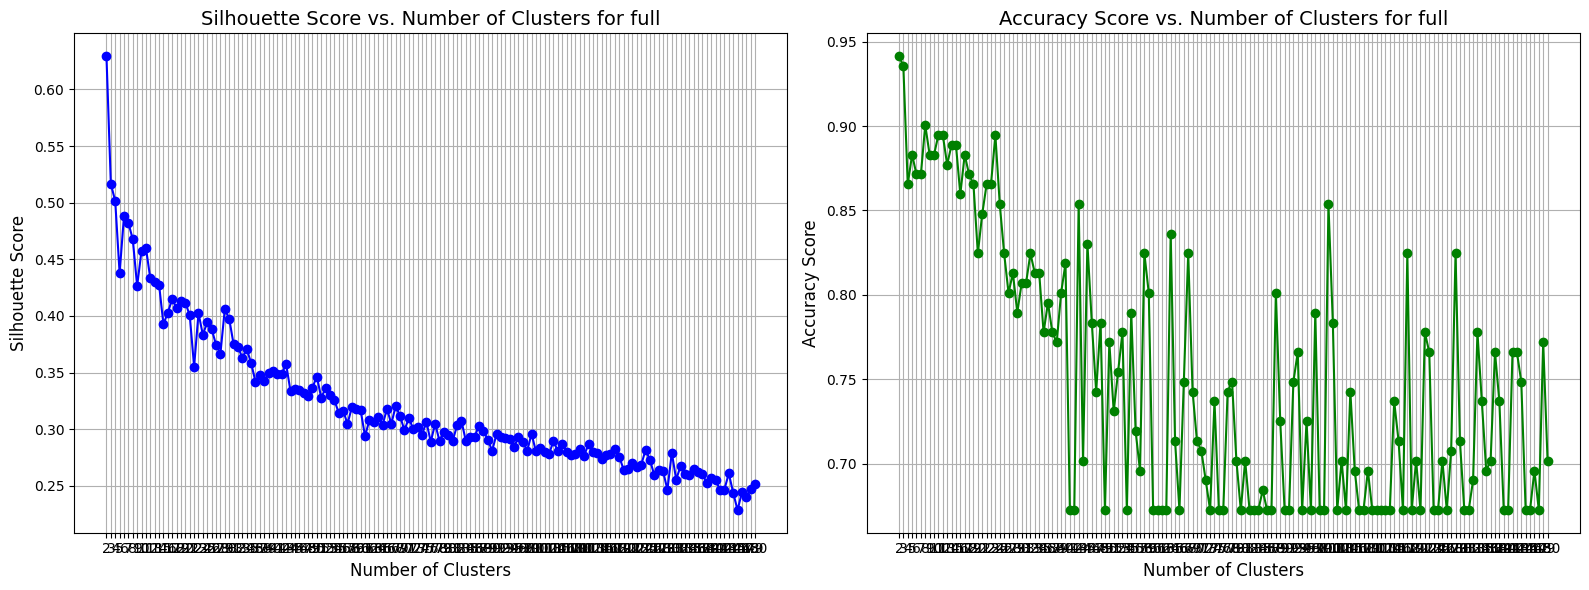

In [28]:
optimal_sil[0], optimal_acc[0] = EM_Clustering('full', X_train, X_test, y_test)

Full covariance with Base Dataset and Max Silhouette:


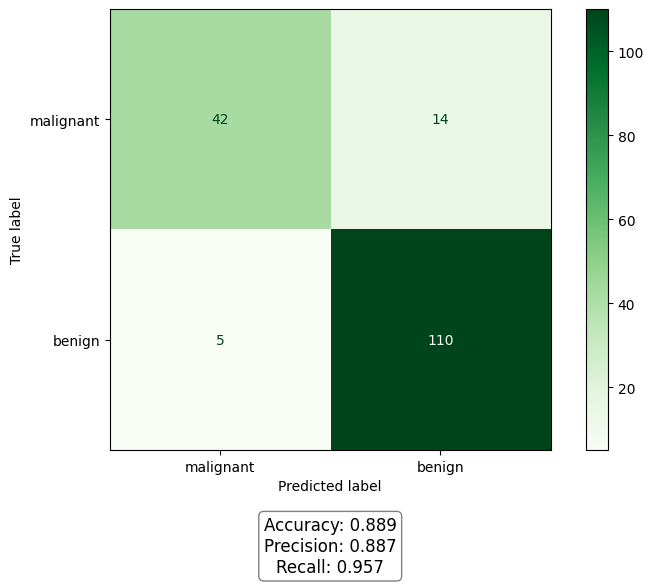

Full covariance with Base Dataset and Max Accuracy:


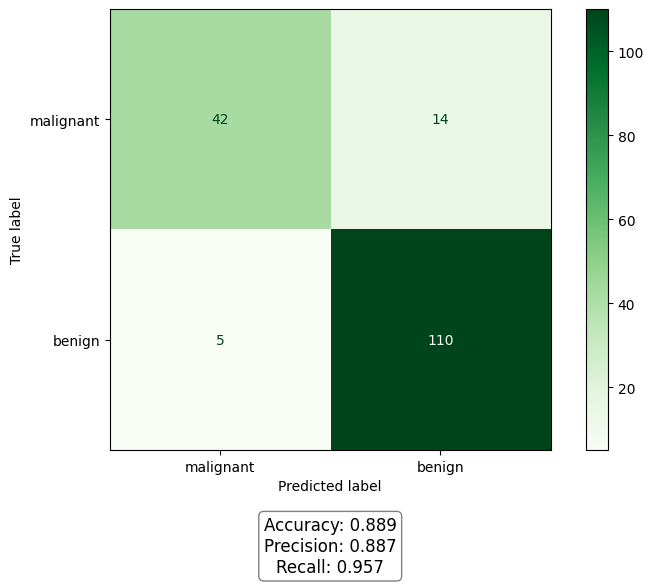

In [29]:
print("Full covariance with Base Dataset and Max Silhouette:")
RBFN(optimal_sil[0], 'full', X_train, X_test, y_train, y_test)

print("Full covariance with Base Dataset and Max Accuracy:")
RBFN(optimal_acc[0], 'full', X_train, X_test, y_train, y_test)

### Tied

For k=2, Silhouette Score: 0.635674131201774, Accuracy Score: 0.8654970760233918
For k=3, Silhouette Score: 0.4724043704178641, Accuracy Score: 0.9415204678362573
For k=4, Silhouette Score: 0.36699272368597574, Accuracy Score: 0.9473684210526315
For k=5, Silhouette Score: 0.31635518735056106, Accuracy Score: 0.9181286549707602
For k=6, Silhouette Score: 0.31099163329986895, Accuracy Score: 0.8596491228070176


For k=7, Silhouette Score: 0.4371113352949598, Accuracy Score: 0.8830409356725146
For k=8, Silhouette Score: 0.4159638680827054, Accuracy Score: 0.9298245614035088
For k=9, Silhouette Score: 0.4318530306563978, Accuracy Score: 0.9005847953216374
For k=10, Silhouette Score: 0.3101000169468533, Accuracy Score: 0.9824561403508771
For k=11, Silhouette Score: 0.32337207894484615, Accuracy Score: 0.9766081871345029
For k=12, Silhouette Score: 0.2057947489447911, Accuracy Score: 0.9766081871345029
For k=13, Silhouette Score: 0.3195754008760073, Accuracy Score: 0.9766081871345029
For k=14, Silhouette Score: 0.3416418793702501, Accuracy Score: 0.9766081871345029
For k=15, Silhouette Score: 0.29236037255388236, Accuracy Score: 0.9473684210526315
For k=16, Silhouette Score: 0.21594487433995954, Accuracy Score: 0.9649122807017544
For k=17, Silhouette Score: 0.2995688376408508, Accuracy Score: 0.9239766081871345
For k=18, Silhouette Score: 0.28707674800399113, Accuracy Score: 0.9532163742690059
For

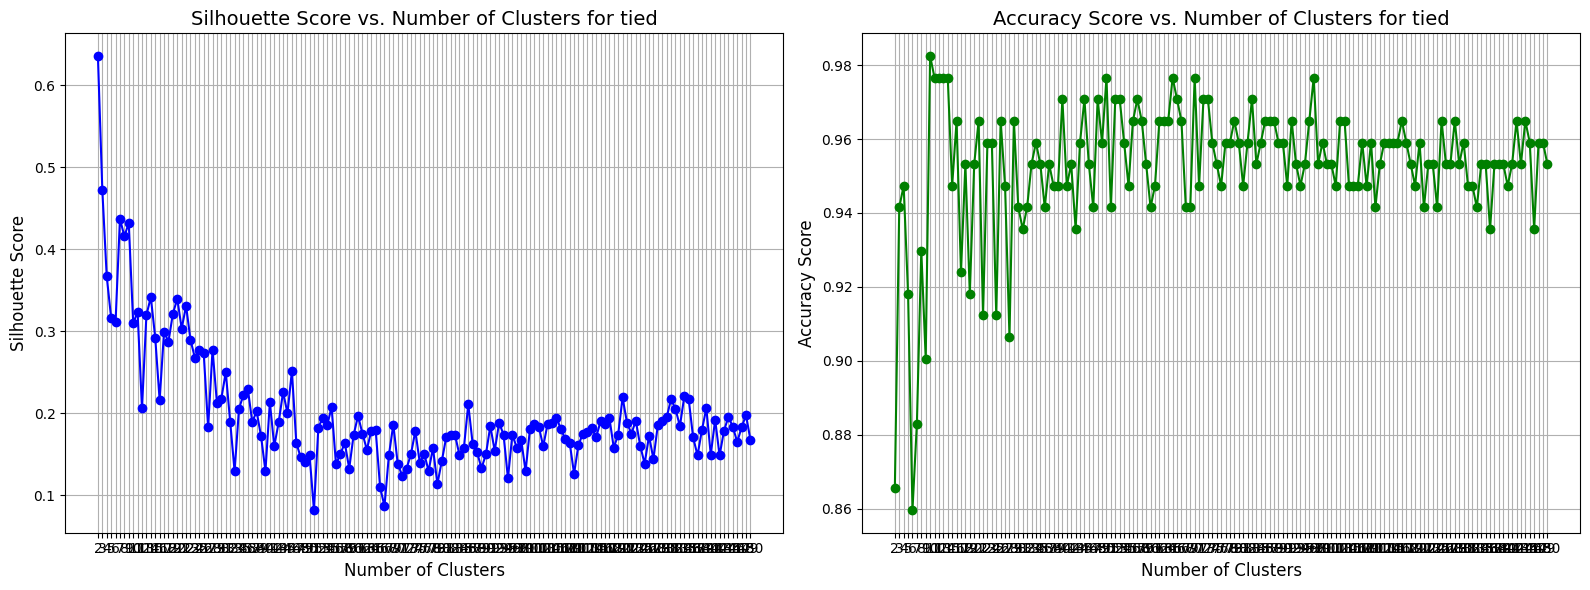

In [30]:
optimal_sil[0], optimal_acc[0] = EM_Clustering('tied', X_train, X_test, y_test)

Tied covariance with Base Dataset and Max Silhouette:


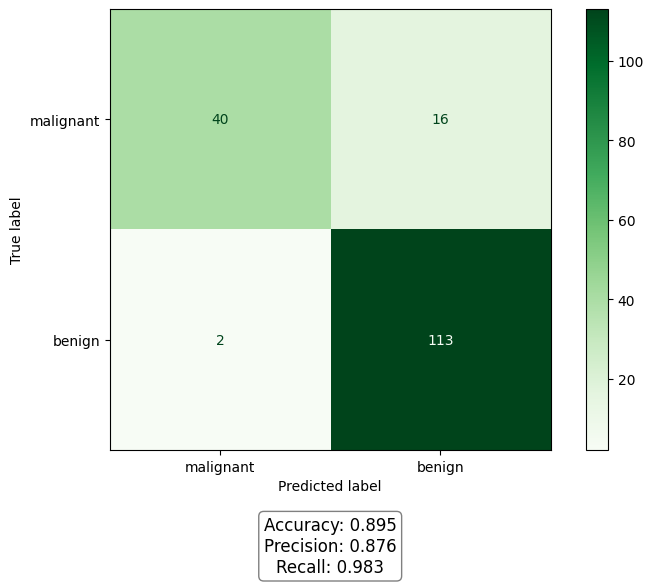

Tied covariance with Base Dataset and Max Accuracy:


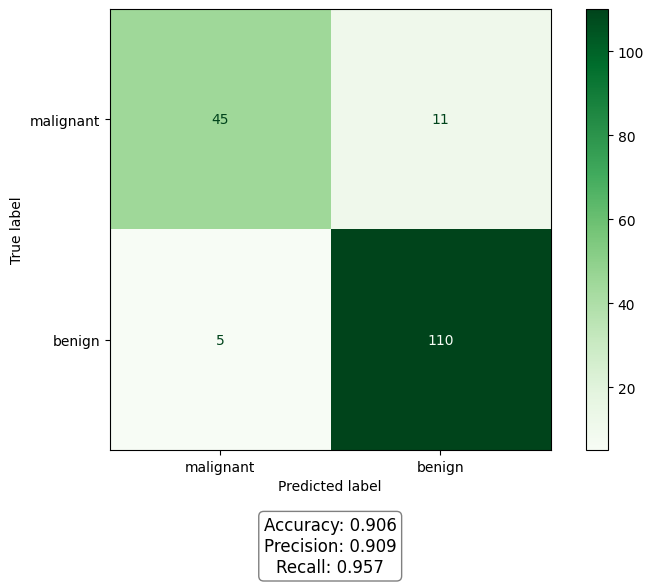

In [31]:
print("Tied covariance with Base Dataset and Max Silhouette:")
RBFN(optimal_sil[0], 'tied', X_train, X_test, y_train, y_test)

print("Tied covariance with Base Dataset and Max Accuracy:")
RBFN(optimal_acc[0], 'tied', X_train, X_test, y_train, y_test)

##  Scaled

### Full

For k=2, Silhouette Score: 0.3045467925883179, Accuracy Score: 0.9649122807017544
For k=3, Silhouette Score: 0.2791533942436824, Accuracy Score: 0.9473684210526315


For k=4, Silhouette Score: 0.20269090209880716, Accuracy Score: 0.8713450292397661
For k=5, Silhouette Score: 0.17069766723794316, Accuracy Score: 0.9122807017543859
For k=6, Silhouette Score: 0.1457011763768678, Accuracy Score: 0.9649122807017544
For k=7, Silhouette Score: 0.1442656781209956, Accuracy Score: 0.9766081871345029
For k=8, Silhouette Score: 0.12446358674259733, Accuracy Score: 0.9298245614035088
For k=9, Silhouette Score: 0.11540237074195574, Accuracy Score: 0.8304093567251462
For k=10, Silhouette Score: 0.11303325680734076, Accuracy Score: 0.9473684210526315
For k=11, Silhouette Score: 0.11539967963910255, Accuracy Score: 0.8011695906432749
For k=12, Silhouette Score: 0.10062400375353907, Accuracy Score: 0.8713450292397661
For k=13, Silhouette Score: 0.11078461964932192, Accuracy Score: 0.9532163742690059
For k=14, Silhouette Score: 0.10873672588030588, Accuracy Score: 0.9122807017543859
For k=15, Silhouette Score: 0.11034471157043549, Accuracy Score: 0.8713450292397661


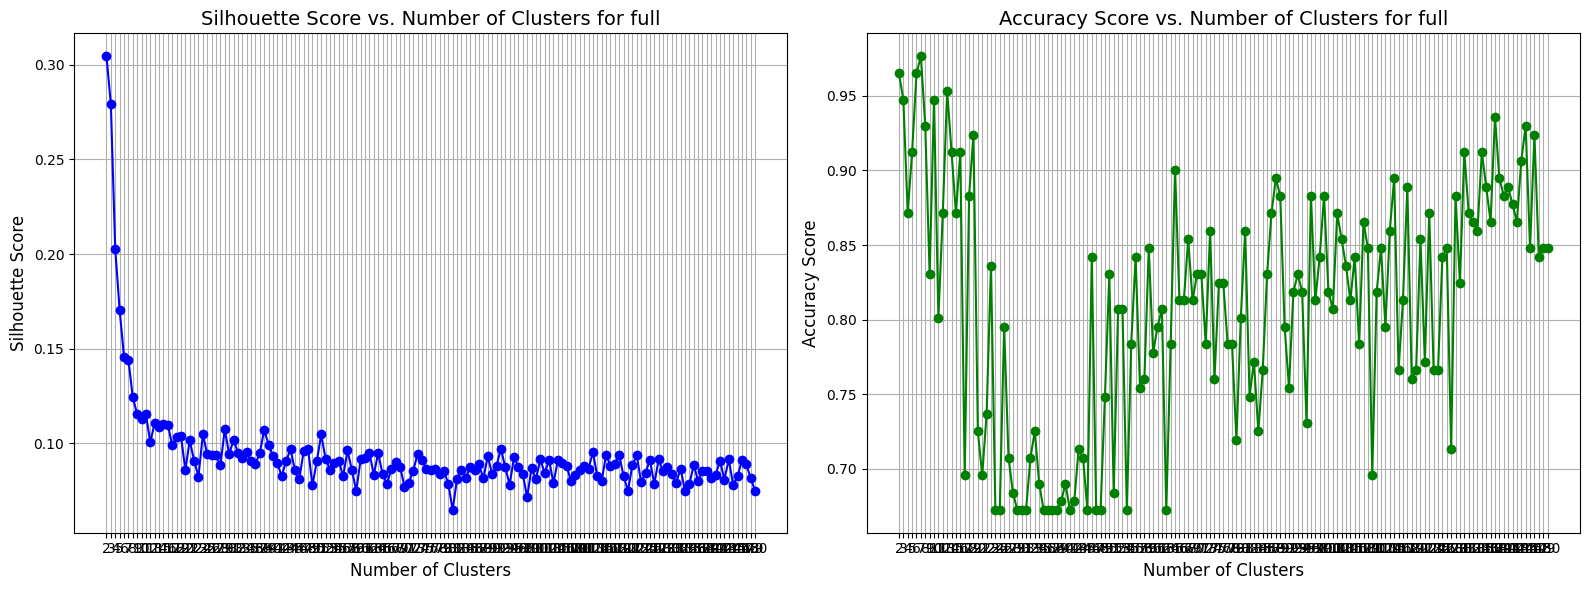

In [32]:
optimal_sil[1], optimal_acc[1] = EM_Clustering('full', X_train_scaled, X_test_scaled, y_test)

Full covariance with Scaled Dataset and Max Silhouette:


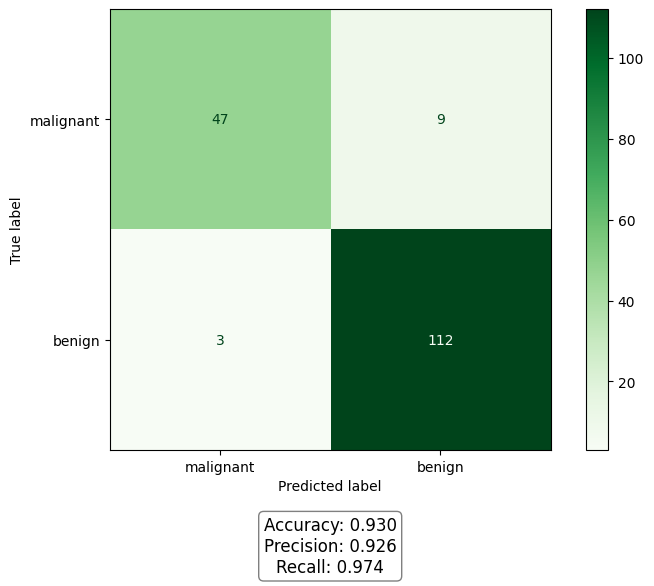

Full covariance with Scaled Dataset and Max Accuracy:


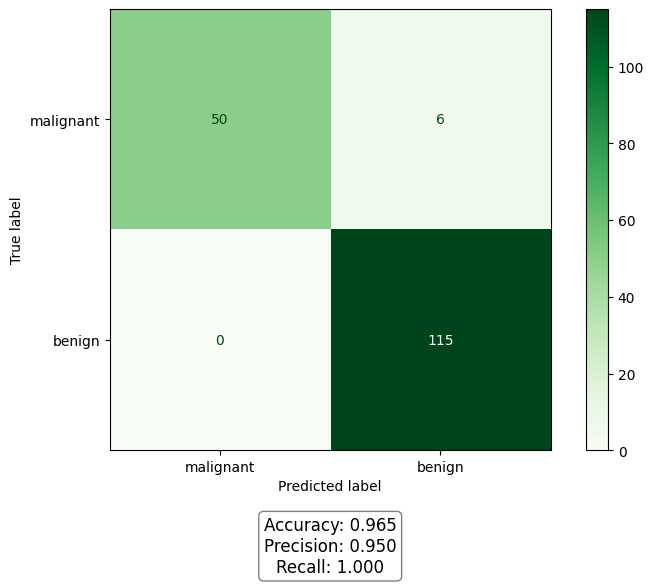

In [33]:
print("Full covariance with Scaled Dataset and Max Silhouette:")
RBFN(optimal_sil[1], 'full', X_train_scaled, X_test_scaled, y_train, y_test)

print("Full covariance with Scaled Dataset and Max Accuracy:")
RBFN(optimal_acc[1], 'full', X_train_scaled, X_test_scaled, y_train, y_test)

### Tied

For k=2, Silhouette Score: 0.31677364654204043, Accuracy Score: 0.9005847953216374
For k=3, Silhouette Score: 0.30990970672793194, Accuracy Score: 0.9181286549707602
For k=4, Silhouette Score: 0.2253614173132478, Accuracy Score: 0.8654970760233918
For k=5, Silhouette Score: 0.20513494623603373, Accuracy Score: 0.9181286549707602
For k=6, Silhouette Score: 0.14640255492515403, Accuracy Score: 0.8947368421052632
For k=7, Silhouette Score: 0.10119914503481615, Accuracy Score: 0.935672514619883
For k=8, Silhouette Score: 0.1399049686195044, Accuracy Score: 0.9532163742690059
For k=9, Silhouette Score: 0.15298125126836556, Accuracy Score: 0.935672514619883
For k=10, Silhouette Score: 0.08802790517056058, Accuracy Score: 0.9473684210526315
For k=11, Silhouette Score: 0.08285425295221943, Accuracy Score: 0.9707602339181286
For k=12, Silhouette Score: 0.10039877579054642, Accuracy Score: 0.9649122807017544
For k=13, Silhouette Score: 0.09541095190957542, Accuracy Score: 0.9649122807017544
For 

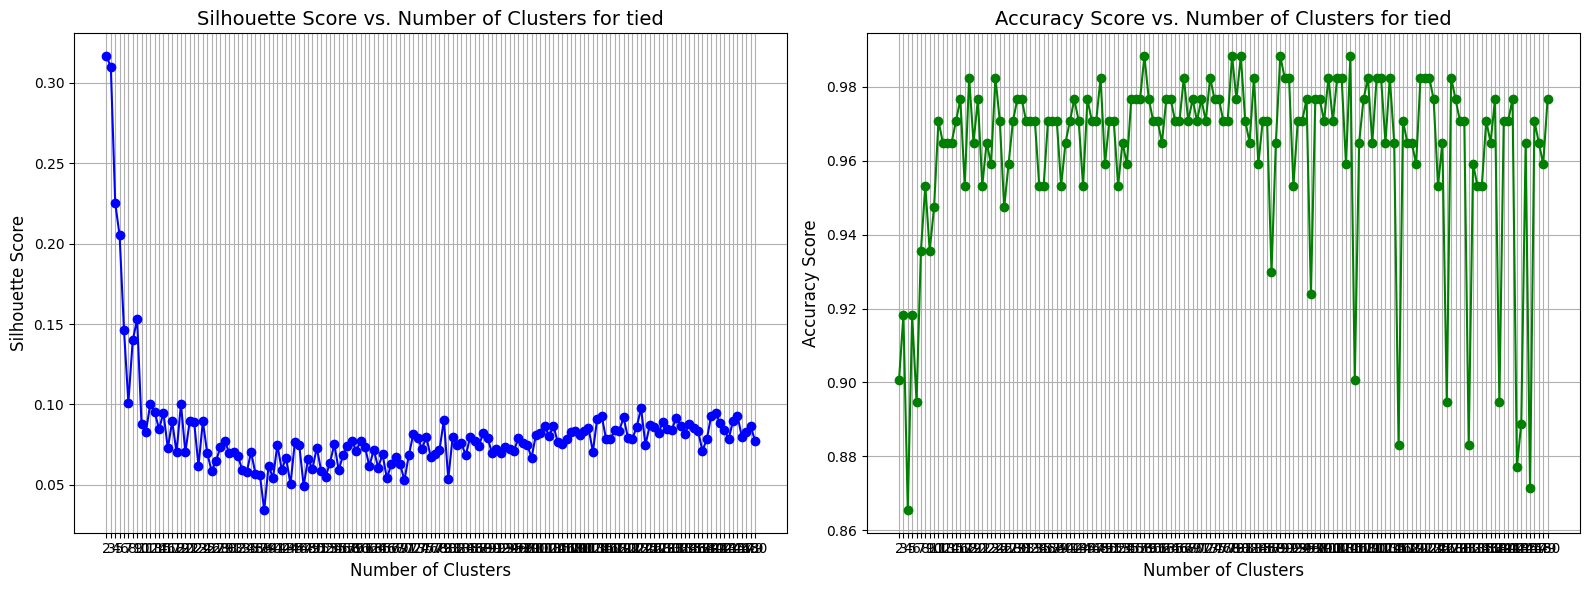

In [34]:
optimal_sil[1], optimal_acc[1] = EM_Clustering('tied', X_train_scaled, X_test_scaled, y_test)

Tied covariance with Scaled Dataset and Max Silhouette:


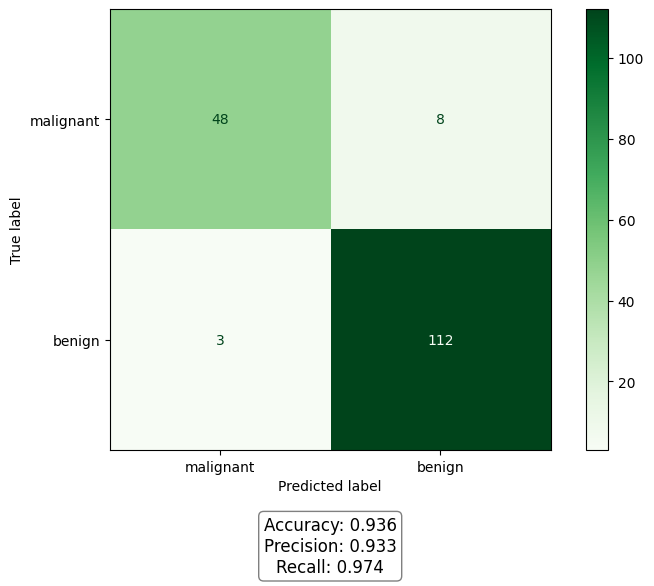

Tied covariance with Scaled Dataset and Max Accuracy:


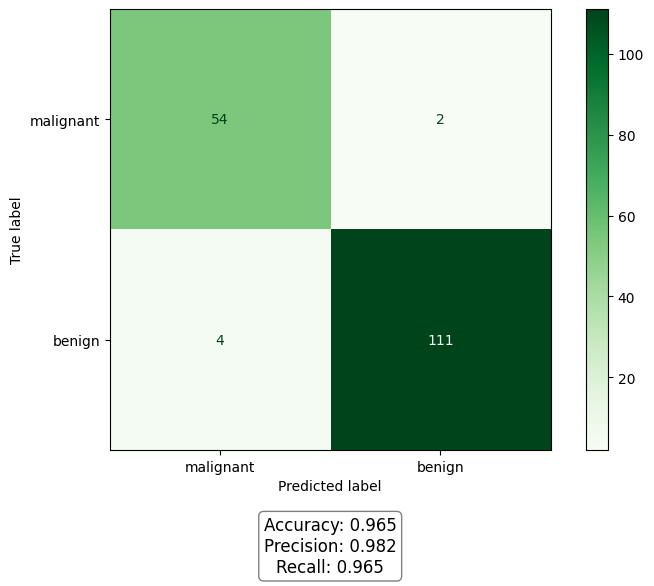

In [35]:
print("Tied covariance with Scaled Dataset and Max Silhouette:")
RBFN(optimal_sil[1], 'tied', X_train_scaled, X_test_scaled, y_train, y_test)

print("Tied covariance with Scaled Dataset and Max Accuracy:")
RBFN(optimal_acc[1], 'tied', X_train_scaled, X_test_scaled, y_train, y_test)

## PCA

### Full

For k=2, Silhouette Score: 0.264413896525006, Accuracy Score: 0.7485380116959064
For k=3, Silhouette Score: 0.2531703088033879, Accuracy Score: 0.8596491228070176
For k=4, Silhouette Score: 0.19065732845005512, Accuracy Score: 0.9298245614035088
For k=5, Silhouette Score: 0.14484983512015737, Accuracy Score: 0.9766081871345029
For k=6, Silhouette Score: 0.17556210989959872, Accuracy Score: 0.9532163742690059
For k=7, Silhouette Score: 0.15011440795481756, Accuracy Score: 0.8304093567251462
For k=8, Silhouette Score: 0.118332865360485, Accuracy Score: 0.935672514619883
For k=9, Silhouette Score: 0.07534903776357466, Accuracy Score: 0.9239766081871345
For k=10, Silhouette Score: 0.11463795550398703, Accuracy Score: 0.9649122807017544
For k=11, Silhouette Score: 0.07438591492066227, Accuracy Score: 0.8947368421052632
For k=12, Silhouette Score: 0.13747792688462415, Accuracy Score: 0.9473684210526315
For k=13, Silhouette Score: 0.09789896298344257, Accuracy Score: 0.9649122807017544
For k=

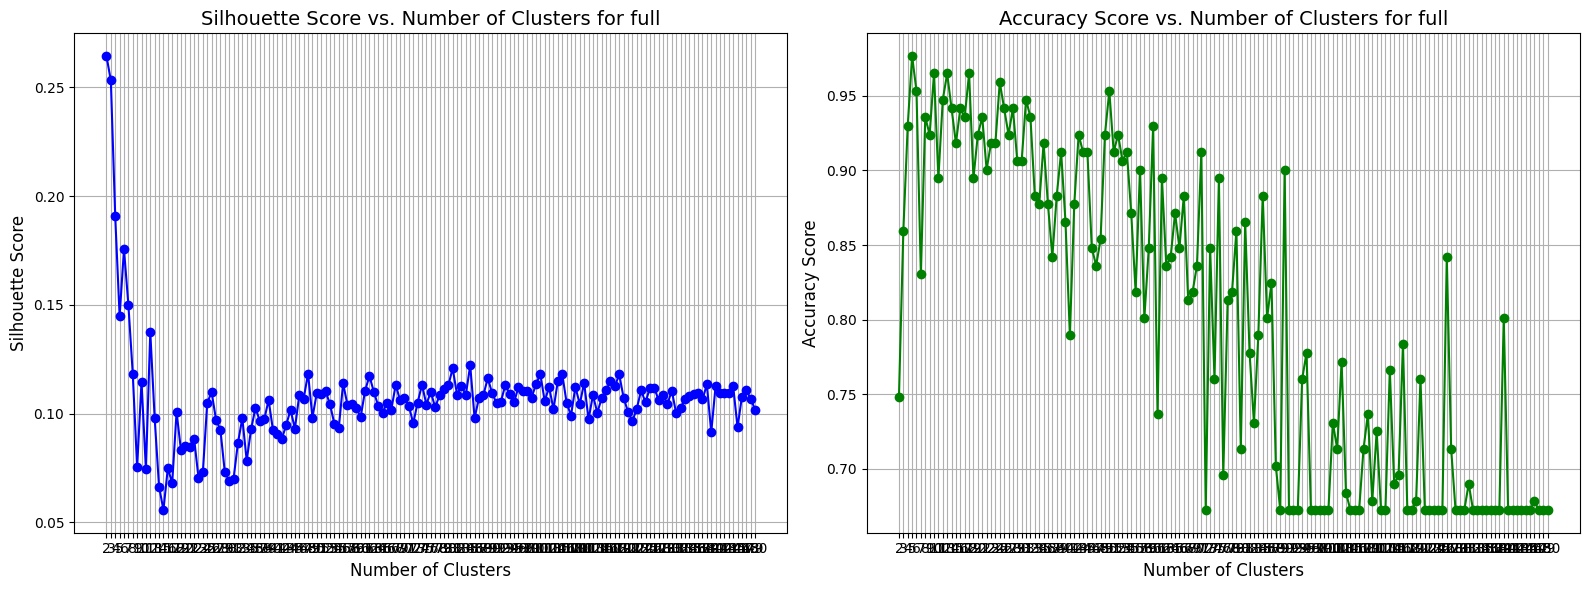

In [36]:
optimal_sil[2], optimal_acc[2] = EM_Clustering('full', X_train_pca, X_test_pca, y_test)

Full covariance with PCA Dataset and Max Silhouette:


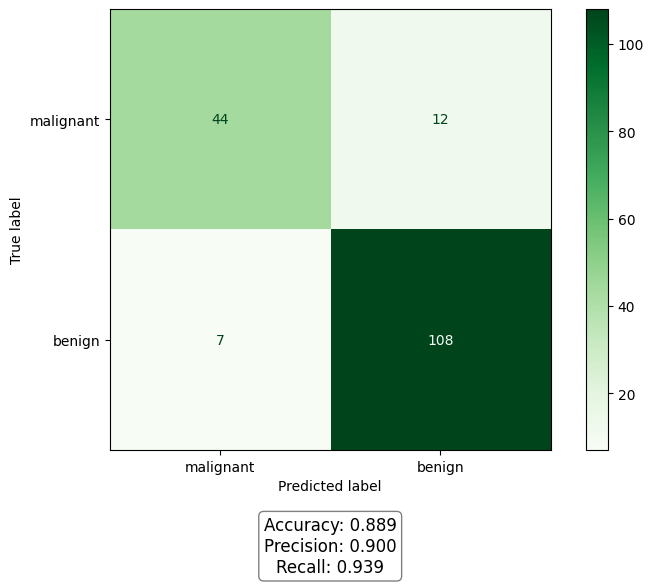

Full covariance with PCA Dataset and Max Accuracy:


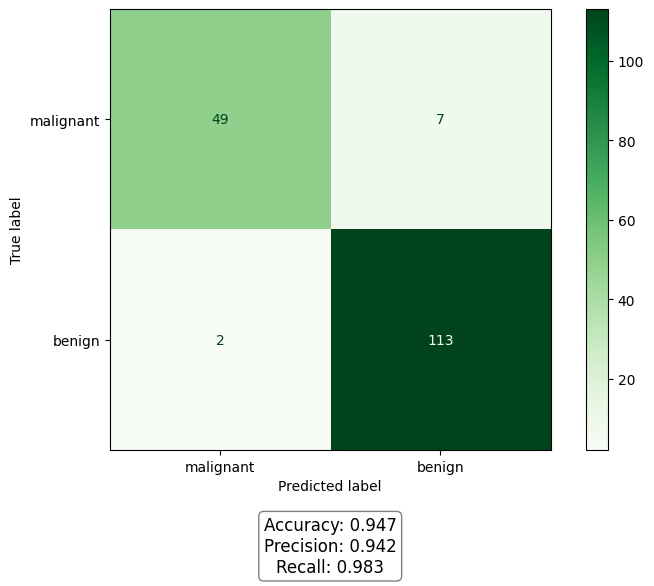

In [37]:
print("Full covariance with PCA Dataset and Max Silhouette:")
RBFN(optimal_sil[2], 'full', X_train_pca, X_test_pca, y_train, y_test)

print("Full covariance with PCA Dataset and Max Accuracy:")
RBFN(optimal_acc[2], 'full', X_train_pca, X_test_pca, y_train, y_test)

### Tied

For k=2, Silhouette Score: 0.3436084147560149, Accuracy Score: 0.9064327485380117
For k=3, Silhouette Score: 0.3246113476603051, Accuracy Score: 0.8304093567251462
For k=4, Silhouette Score: 0.33393991477195606, Accuracy Score: 0.8947368421052632
For k=5, Silhouette Score: 0.2359087576017011, Accuracy Score: 0.9649122807017544
For k=6, Silhouette Score: 0.23829531577026902, Accuracy Score: 0.9649122807017544
For k=7, Silhouette Score: 0.2327283938708944, Accuracy Score: 0.9590643274853801
For k=8, Silhouette Score: 0.17338058629710376, Accuracy Score: 0.9532163742690059
For k=9, Silhouette Score: 0.1400980059812897, Accuracy Score: 0.9590643274853801
For k=10, Silhouette Score: 0.12074584137023599, Accuracy Score: 0.9532163742690059
For k=11, Silhouette Score: 0.12384081811843774, Accuracy Score: 0.9707602339181286
For k=12, Silhouette Score: 0.09944509243367937, Accuracy Score: 0.9707602339181286
For k=13, Silhouette Score: 0.09086036985873973, Accuracy Score: 0.9707602339181286
For k

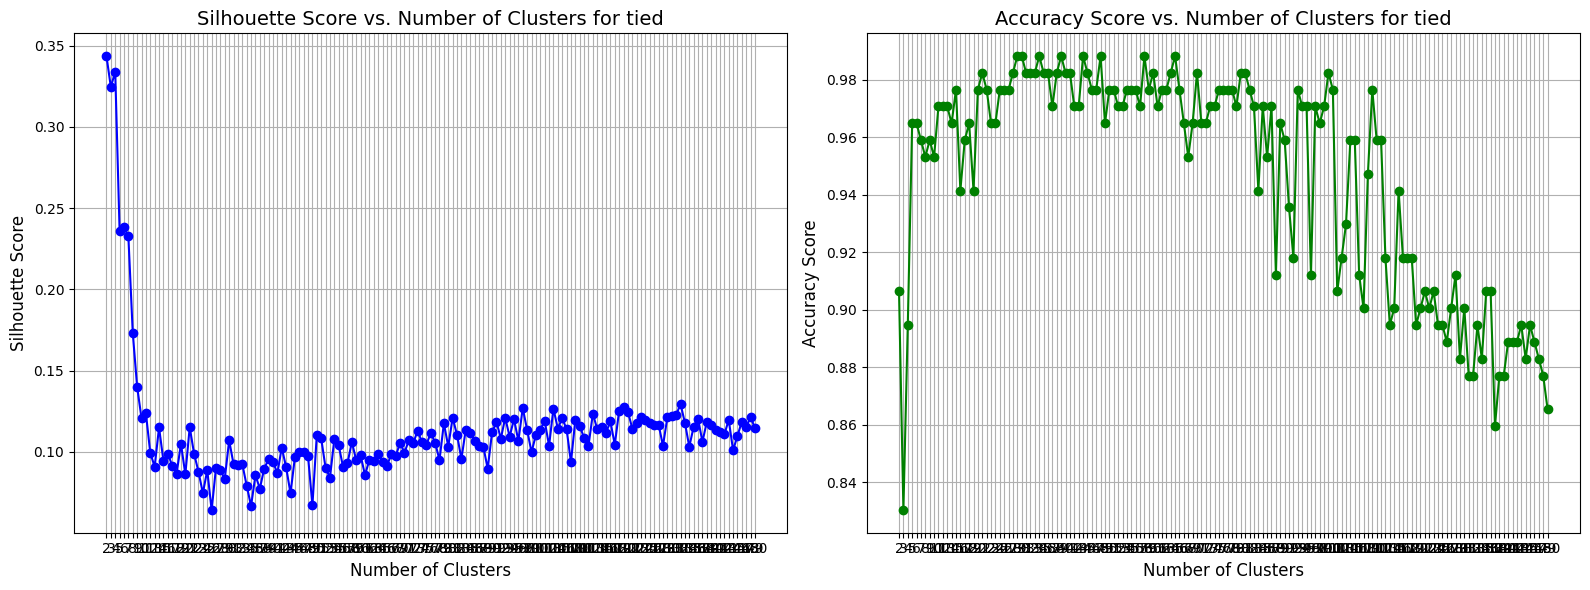

In [38]:
optimal_sil[2], optimal_acc[2] = EM_Clustering('tied', X_train_pca, X_test_pca, y_test)

Tied covariance with PCA Dataset and Max Silhouette:


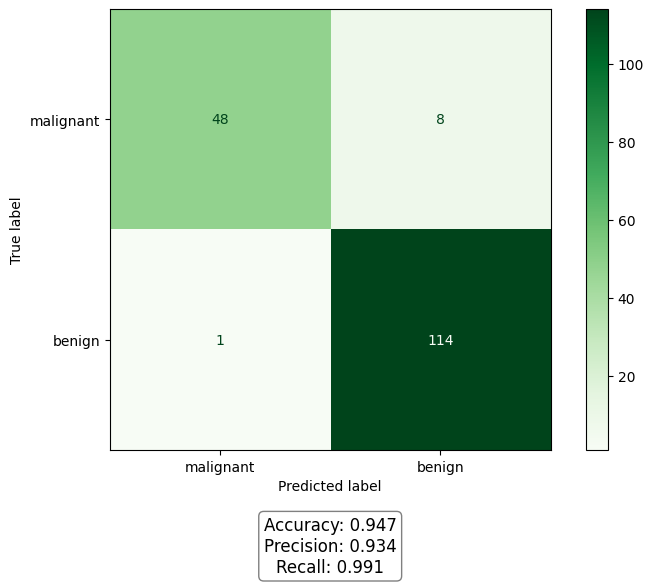

Tied covariance with PCA Dataset and Max Accuracy:


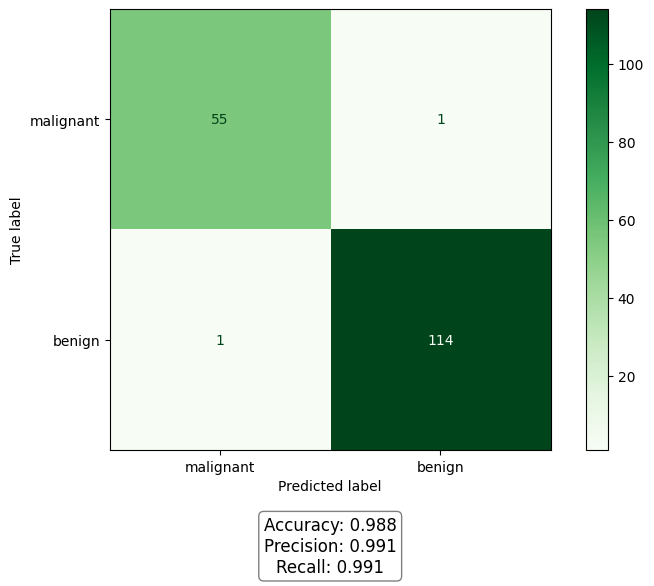

In [39]:
print("Tied covariance with PCA Dataset and Max Silhouette:")
RBFN(optimal_sil[2], 'tied', X_train_pca, X_test_pca, y_train, y_test)

print("Tied covariance with PCA Dataset and Max Accuracy:")
RBFN(optimal_acc[2], 'tied', X_train_pca, X_test_pca, y_train, y_test)